# 5 - Convolution Sequence to Sequence Learning

해당 내용은 2017년도 [Convolutional Sequence to Sequence Learning](https://arxiv.org/abs/1705.03122) 논문의 내용의 컨셉을 구현한 것임.

## Introduction

<p align="center"><img src="../asset/5(1).png"></p>

본 모델은 이제까지와 다르게 reccurent 한 요소 없이 convolution layer로 구성하였다.

## Data Preparation

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

import en_core_web_sm, de_core_news_sm

spacy_de = de_core_news_sm.load()
spacy_en = en_core_web_sm.load()

def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

지금까지 RNN에 들어갈 때 sequence는 [sequence_length, batch_size] 와 같은 shape 이었지만, CNN에 들어가기 위해서는 [batch_size, sequence_length]여야함

따라서 `batch_first=True`로 설정해준다

In [2]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

In [3]:
train_data, valid_data, test_data = Multi30k.splits(
    exts=('.de', '.en'),
    fields=(SRC, TRG)
)

SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     device = device
)

## Building the Model

`Encoder`은 input sentence를 받아서 *context vector*를 생성

`Decoder`은 context vector를 통해 *output sentence*를 생성

### Encoder

기존의 RNN-based encoder에서는 *single context vector* $z$를 생성했다면, CNN-based에서는 token 하나당 두개의 *context vector*를 생성한다.

Conved vector + Combined vector

<p align="center"><img src="../asset/5(2).png"></p>

1. `token`이 *embedding layer*를 거친다. 또한 RNN과 다르게 위치정보를 주기위해 *positional embedding layer*를 사용

2. `token`과 `positional embedding`을 element-wise로 더한 뒤, `embedding vector`로 사용한다.

3. 이후 *linear layer*를 통해 hidden vector로 변환해주고, 이는 Conv block를 거친다.

4. Conv block을 거치고 *linear layer*를 통해 다시 embedded dimension로 변환해준다. 이를 `conved vector`라 부름

5. 모든 `conved vector`와 `embedding vector`를 element-wise하게 더해준 것을 `combined vector`라고 한다.


### Convolutional Blocks

하나의 block은 1d convolution과 activation function으로 구성되어있다.

<p align="center"><img src="../asset/5(3).png"></p>

- 1D Convolution

    - Hidden dimension 크기를 유지해주기 위해서 padding을 이용해준다.

    - Padding 크기는 간단하게 `filter_size - 1) / 2`로 해주면 됨

    - input이 $d$-dimensional vector 단어를 $k$개 포함하는 $X \in \mathbb{R}^{k \times d}$

    - output은 $\mathbb{R}^{k \times 2d}$ 이다. 

- GLU + Residual Connection

    - Convolution을 거쳐서 dimension이 2배가 된 값에 *gated linear unit*을 적용한다.

    - 이는 output vector를 2개로 (A, B) 나눈뒤 $A \otimes \sigma(B)$ 를 수행해준다.

    - 즉, A 벡터는 그대로 들어가고 B는 sigmoid를 거친 후 A와 element-wise multiplication 을 거친다.

    - 이후 residual connection을 통해 layer를 deep하게 쌓아준다.

### Implementation

`scale`은 논문에서 network의 output의 variance를 줄여주기 위함이다.

문장의 길이가 더 긴 dataset을 사용하면 `max_length`를 더 길게 설정해준다

In [4]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, kernel_size, dropout, device, max_length=100):
        super().__init__()

        assert kernel_size % 2 == 1, 'Kernel size must be odd'

        self.device = device
        self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)
        self.tok_embedding = nn.Embedding(input_dim, emb_dim)
        self.pos_embedding = nn.Embedding(max_length, emb_dim)

        self.emb2hid = nn.Linear(emb_dim, hid_dim)
        self.hid2emb = nn.Linear(hid_dim, emb_dim)

        self.conv_blocks = nn.ModuleList([
            nn.Conv1d(
                in_channels=hid_dim,
                out_channels=2 * hid_dim,
                kernel_size=kernel_size,
                padding=(kernel_size - 1) // 2
            )
            for _ in range(n_layers)
        ])

        self.dropout = nn.Dropout(dropout)


    def forward(self, src):
        '''
        src - [batch_size, src_len] # RNN 계열은 [src_len, batch_size] 였다.
        '''

        batch_size = src.shape[0]
        src_len = src.shape[1]

        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        # pos - [batch_size, src_len]

        tok_embedded = self.tok_embedding(src)
        pos_embedded = self.pos_embedding(pos)
        # tok, pos_embedded - [batch_size, src_len, emb_dim]

        embedded = self.dropout(tok_embedded + pos_embedded)
        # embedded - [batch_size, src_len, emb_dim]

        conv_input = self.emb2hid(embedded)
        # conv_input - [batch_size, src_len, hid_dim]

        conv_input = conv_input.permute(0, 2, 1)
        # conv_input - [batch_size, hid_dim, src_len]

        for i, conv in enumerate(self.conv_blocks):
            conved = conv(self.dropout(conv_input))
            # conved - [batch_size, 2 * hid_dim, src_len]

            conved = F.glu(conved, dim=1)
            # conved - [batch_size, hid_dim, src_len]

            conved = (conved + conv_input) * self.scale

            conv_input = conved

        conved = self.hid2emb(conved.permute(0, 2, 1))
        # conved - [batch_size, src_len, emb_dim]

        combined = (conved + embedded) * self.scale

        return conved, combined

### Decoder

RNN 계열과 다르게 sequential하게 예측하는 것이 아니라 병렬적으로 한번에 계산된다.

<p align="center"><img src="../asset/5(4).png"></p>

Decoder도 위의 Encoder과 거의 유사한 구조이고 유사한 input을 받지만, 다른 것은 Encoder에서 구한 `conved vector`와 `combined vector`가 convolutional block에 들어간 후 prediction을 하는 것, 그리고 convolutional block 내에서의 연산과정이 다르다.

<p align="center"><img src="../asset/5(5).png"></p>

1. Encoder의 block과 다른 점은 padding이 sequence의 양끝이 아니라 앞에 붙혀주는 것임.

만약 encoder과 같게 아래 그림과 같이 **양 옆에** padding을 하게 되면 `<sos>`를 받고 다음 단어를 예측해야되는데, convolution 연산 과정에서 true 값인 `two`를 보면서 예측하기 때문에 학습이 잘 안된다.

<p align="center"><img src="../asset/5(6).png"></p>

2. 또 다른 점은 GLU activation 이후에 attention 연산을 수행한다는 것이다.

Encoder에서 얻어진 global representation과 특정 token의 embedding 사이의 attention을 계산한다.

우선 token (hidden dimension) 을 embedding dimension과 같은 크기로 맞춰주고, `encoded conved`과 얼마나 match 되는지, 즉 attention score를 계산한다. 이후에 얻어진 attention score로 `encoded combined`의 weighted 값을 얻고 이를 반환해준다

본 논문에서는 `encoded conved`는 전체 sequence에 대한 larget context를 가지고 있고, `encoded combined`는 특정 token에 대한 information을 더 많이 가지고 있어서, prediction하기에 적합하다고 한다.

</br>

### Decoder Implementation

In [6]:
class Decoder(nn.Module):
    def __init__(
                self, output_dim, emb_dim, hid_dim,
                n_layers, kernel_size, dropout,
                trg_pad_idx, device, max_length=100
                ):
        super().__init__()

        self.kernel_size = kernel_size
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)
        
        self.tok_embedding = nn.Embedding(output_dim, emb_dim)
        self.pos_embedding = nn.Embedding(max_length, emb_dim)
        
        self.emb2hid = nn.Linear(emb_dim, hid_dim)
        self.hid2emb = nn.Linear(hid_dim, emb_dim)
        
        self.attn_hid2emb = nn.Linear(hid_dim, emb_dim)
        self.attn_emb2hid = nn.Linear(emb_dim, hid_dim)

        self.fc_out = nn.Linear(emb_dim, output_dim)

        self.conv_blocks = nn.ModuleList([
            nn.Conv1d(
                in_channels=hid_dim,
                out_channels=2 * hid_dim,
                kernel_size=kernel_size, # padding 구현은 이따가
            )
            for _ in range(n_layers)
        ])

        self.dropout = nn.Dropout(dropout)


    def calculate_attention(self, embedded, conved, encoder_conved, encoder_combined):
        '''
        embedded - [batch_size, trg_len, emb_dim]
        conved - [batch_size, hid_dim, trg_len]
        encoder_conved, combined - [batch_size, src_len, emb_dim]
        '''

        conved_emb = self.attn_hid2emb(conved.permute(0, 2, 1))
        combined = (conved_emb + embedded) * self.scale

        energy = torch.matmul(combined, encoder_conved.permute(0, 2, 1))
        # energy - [batch_size, trg_len, src_len]

        attention = F.softmax(energy, dim=2)

        attended_encoding = torch.matmul(attention, encoder_combined)
        #attended_encoding = [batch size, trg len, emd dim]

        attended_encoding = self.attn_emb2hid(attended_encoding)
        #attended_encoding = [batch size, trg len, hid dim]

        attended_combined = (conved + attended_encoding.permute(0, 2, 1)) * self.scale

        return attention, attended_combined


    def forward(self, trg, encoder_conved, encoder_combined):
        '''
        trg - [batch_size, trg_len]
        encoder_conved, combined - [batch_size, src_len, emb_dim]
        '''

        batch_size = trg.shape[0]
        trg_len = trg.shape[1]

        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        tok_embedded = self.tok_embedding(trg)
        pos_embedded = self.pos_embedding(pos)

        embedded = self.dropout(tok_embedded + pos_embedded)

        conv_input = self.emb2hid(embedded)

        conv_input = conv_input.permute(0, 2, 1)

        batch_size = conv_input.shape[0]
        hid_dim = conv_input.shape[1]

        for i, conv in enumerate(self.conv_blocks):

            conv_input = self.dropout(conv_input)

            padding = torch.zeros(batch_size, hid_dim, self.kernel_size - 1).fill_(self.trg_pad_idx).to(self.device)

            padded_conv_input = torch.cat((padding, conv_input), dim=2)

            conved = conv(padded_conv_input)

            conved = F.glu(conved, dim=1)

            attention, conved = self.calculate_attention(embedded, conved, encoder_conved, encoder_combined)

            conved = (conved + conv_input) * self.scale

            conv_input = conved

        conved = self.hid2emb(conved.permute(0, 2, 1))

        output = self.fc_out(self.dropout(conved))

        return output, attention       

### Seq2Seq

해당 Decoder에서는 `<eos>` token이 들어갈 필요가 없어서 이를 제거해준다.

또한 기존의 RNN 기반과는 다르게 conv모델은 병렬적으로 한번에 계산되기 때문에 teacher_forcing technique을 적용할 수 없다.

In [7]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, trg):
        '''
        src - [batch_size, src_len]
        trg - [batch_size, trg_len - 1]
        '''
        encoder_conved, encoder_combined = self.encoder(src)

        output, attention = self.decoder(trg, encoder_conved, encoder_combined)

        return output, attention

### Training the Seq2Seq Model

In [8]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
EMB_DIM = 256
HID_DIM = 512 # each conv. layer has 2 * hid_dim filters
ENC_LAYERS = 10 # number of conv. blocks in encoder
DEC_LAYERS = 10 # number of conv. blocks in decoder
ENC_KERNEL_SIZE = 3 # must be odd!
DEC_KERNEL_SIZE = 3 # can be even or odd
ENC_DROPOUT = 0.25
DEC_DROPOUT = 0.25
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
    
enc = Encoder(INPUT_DIM, EMB_DIM, HID_DIM, ENC_LAYERS, ENC_KERNEL_SIZE, ENC_DROPOUT, device)
dec = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM, DEC_LAYERS, DEC_KERNEL_SIZE, DEC_DROPOUT, TRG_PAD_IDX, device)

model = Seq2Seq(enc, dec).to(device)

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 37,351,429 trainable parameters


In [10]:
optimizer = optim.Adam(model.parameters())

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

지금까지의 RNN 기반 decoder에서는 sequential하게 loop를 돌면서 `<eos>`까지 가지 않아서 고려할 필요가 없었음.

해당 모델에서는 `<eos>`를 직접 slice해주어야 함

target_input = [$sos, x_1, x_2, x_3, eos$]

target_input[:-1] = [$sos, x_1, x_2, x_3$]

output = [$y_1, y_2, y_3, eos$]

</br>

또한 `contiguous()`

In [16]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
        
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
        
        output_dim = output.shape[-1]
        
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
        
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [15]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
        
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]

            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)

            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [13]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [17]:
N_EPOCHS = 10
CLIP = 0.1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '5-seq2seq-model.pt')
    
    print(f'Epoch : {epoch+1:02} | Time : {epoch_mins}m {epoch_secs}s | Train loss : {train_loss:.5f} | Valid loss : {valid_loss:.5f}')

Epoch : 01 | Time : 0m 26s | Train loss : 4.02320 | Valid loss : 2.92189
Epoch : 02 | Time : 0m 26s | Train loss : 2.94968 | Valid loss : 2.35547
Epoch : 03 | Time : 0m 26s | Train loss : 2.57158 | Valid loss : 2.10549
Epoch : 04 | Time : 0m 26s | Train loss : 2.35396 | Valid loss : 1.98210
Epoch : 05 | Time : 0m 25s | Train loss : 2.20248 | Valid loss : 1.90539
Epoch : 06 | Time : 0m 24s | Train loss : 2.08823 | Valid loss : 1.86787
Epoch : 07 | Time : 0m 24s | Train loss : 2.00448 | Valid loss : 1.80725
Epoch : 08 | Time : 0m 25s | Train loss : 1.92861 | Valid loss : 1.78907
Epoch : 09 | Time : 0m 26s | Train loss : 1.87114 | Valid loss : 1.76760
Epoch : 10 | Time : 0m 26s | Train loss : 1.81790 | Valid loss : 1.73462


In [18]:
model.load_state_dict(torch.load('5-seq2seq-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.807 | Test PPL:   6.092 |


### Inference

`translate_sentence` 함수에서 하는 일

1. tokenize 안 되어있는 원 문장이면 tokenize 해주기
2. <sos>, <eos> token 붙혀주기
3. `vocab.stoi` 이용해서  문장을 양자화
4. 모델의 Encoder 결과 출력
5. <sos> 토큰을 decoder에 넣어서 prediction 시작
6. prediction에 <eos>가 나올때까지 반복
7. 완료된 token들을 `vocab.itos` 이용하여 문장으로 바꿔줌

In [19]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de_core_news_sm')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)

    with torch.no_grad():
        encoder_conved, encoder_combined = model.encoder(src_tensor)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, encoder_conved, encoder_combined)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

다음은 모델이 어떤 token에 attention을 주었느지를 시각화하는 함수이다.

In [21]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
        
    attention = attention.squeeze(0).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                       rotation=45)
    ax.set_yticklabels(['']+translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

Training set에 포함되어있는 문장 inference

In [22]:
example_idx = 2

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'kleines', 'mädchen', 'klettert', 'in', 'ein', 'spielhaus', 'aus', 'holz', '.']
trg = ['a', 'little', 'girl', 'climbing', 'into', 'a', 'wooden', 'playhouse', '.']


In [23]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'little', 'girl', 'is', 'climbing', 'in', 'a', 'playhouse', 'made', 'of', 'wood', '.', '<eos>']


/home/hwan/anaconda3/envs/torch1.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == "":
/home/hwan/anaconda3/envs/torch1.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


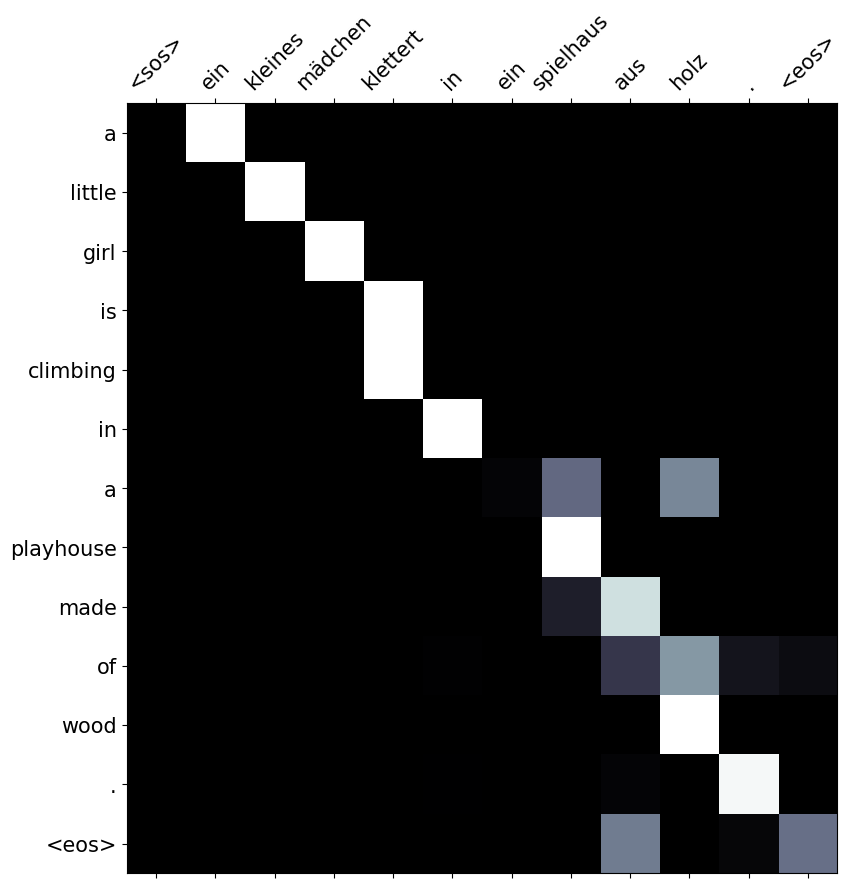

In [24]:
display_attention(src, translation, attention)

Validation set에 포함되어있는 문장 inference

In [25]:
example_idx = 2

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

src = ['ein', 'junge', 'mit', 'kopfhörern', 'sitzt', 'auf', 'den', 'schultern', 'einer', 'frau', '.']
trg = ['a', 'boy', 'wearing', 'headphones', 'sits', 'on', 'a', 'woman', "'s", 'shoulders', '.']
predicted trg = ['a', 'boy', 'with', 'headphones', 'sitting', 'on', 'the', 'shoulders', 'of', 'a', 'woman', '.', '<eos>']


/home/hwan/anaconda3/envs/torch1.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == "":
/home/hwan/anaconda3/envs/torch1.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


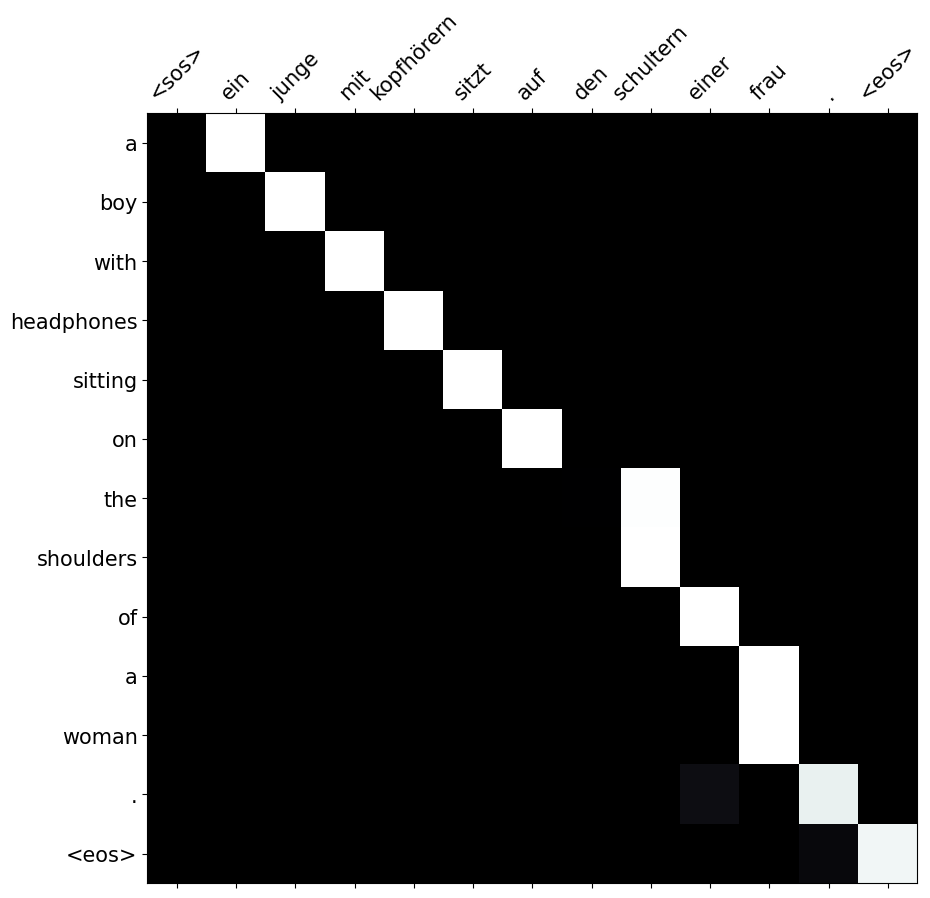

In [26]:
display_attention(src, translation, attention)

### BLEU score

- Bilingual Evaluation Understudy Score

- Model output과 사람의 translation이 얼마나 유사한지 비교하는 번역에 대한 성능을 측정하는 방법

- N-gram을 기반으로 측정

In [27]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

In [28]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 34.71


In [30]:
import torchtext

print(torchtext.__version__)

0.6.0
